# Weighted Sampling with Precipitation

Since the distribution of the precipitation amount is highly skewed (mostly no rain and rare heavy rainfall), we want to train on the heavy rainfall cases multiple times in order to balance the dataset. Hence, we need a 'weighted sampling' scheme before we train the model.

Before we proceed, let's check the distribution of the rainfall. Let's investigate the interval:

  -  1 mm/hr
  -  5 mm/hr
  - 10 mm/hr
  - 20 mm/hr
  - 40 mm/hr


In [1]:
import numpy as np
import pandas as pd

# Read data
tmp = pd.read_csv('./data/t1hr.csv')
print(tmp.head())
# Move date to index
dates = tmp['date']
t1hr = tmp.iloc[:,1:]
print(t1hr.shape)
# Max of stations
t1hr_max = t1hr.max(axis=1)

# Create y
y = pd.DataFrame({'timestamp':dates, 'y':t1hr_max})
y.head()

         date  C0A580  C0A970  466940  C0A540  C0A550  C0A9A0  C0AC60  C0A870  \
0  2013010101     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1  2013010102     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2  2013010103     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3  2013010104     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4  2013010105     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   466920  ...  C0A9I1  C0AD50  C0A9B0  C0A560  C0A950  C0A940  C0A570  \
0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   C0A980  C0A9C0  C0AD40  
0     0.0     0.0     0.0  
1     0.0   

,timestamp,y
0,2013010101,0.0
1,2013010102,0.0
2,2013010103,0.0
3,2013010104,0.0
4,2013010105,0.0


(array([23583,  6933,  2354,  1316,   639,   239], dtype=int64), array([  0,   1,   5,  10,  20,  40, 200]))


(array([23583.,  6933.,  2354.,  1316.,   639.,   239.]),
 array([  0,   1,   5,  10,  20,  40, 200]),
 <a list of 6 Patch objects>)

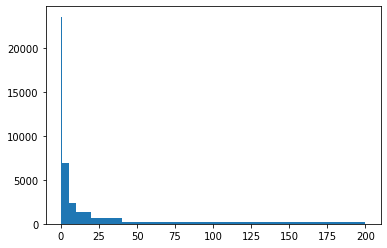

In [2]:
prec_hist = np.histogram(t1hr_max, bins=[0, 1, 5, 10, 20, 40, 200])
print(prec_hist)

# Making plot
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(t1hr_max, bins=[0, 1, 5, 10, 20, 40, 200])

From the histogram above, we can see that for heavy rainfall (>40mm/hr) cases, we shall sample 100 times more than the no rain cases.


## Sampling Scheme

Let's say we have $N$ samples in total, and we want to do 100 times of resampling. Each of the $N$ samples will be used at least once, and we need to estimate how may epochs each bin will be used for.

In [8]:
# Calculate the ratio
print('Normalized case number:')
print(prec_hist[0]/prec_hist[0][-1])
# Calculate normalized probability
p = 1/(prec_hist[0]/prec_hist[0][-1])
p = p/sum(p)
print('Normalized sampling probability')
print(np.round(p, 4))
# Total Sample
n = sum(prec_hist[0])*100
print('Total sample size (sample size * epochs):' + str(n))
print('Number of samples for each bin:')
print(np.round(n*p))
print('Number of repeat for each bin:')
print(np.round(n*p/prec_hist[0]))
print(sum(np.round(n*p/prec_hist[0])*prec_hist[0]))

Normalized case number:
[98.67364017 29.0083682   9.84937238  5.50627615  2.67364017  1.        ]
Normalized sampling probability
[0.006  0.0203 0.0597 0.1067 0.2198 0.5876]
Total sample size (sample size * epochs):3506400
Number of samples for each bin:
[  20881.   71029.  209195.  374199.  770651. 2060444.]
Number of repeat for each bin:
[1.000e+00 1.000e+01 8.900e+01 2.840e+02 1.206e+03 8.621e+03]
3507216.0


Therefore, we expect to use HR cases 59 times, 20\~40mm/hr cases 22 times, 10\~20mm/hr 11 times, 5\~10mm/hr 6 times, and 1\~5mm/hr 2 times. In practice, we can dynamically calculate the actual values.

In [31]:
def generate_samples(dinfo, prec_bins=[0, 1, 5, 10, 20, 40, 500], num_epoch=100, shuffle=True):
    # Analysis the Precipitation
    prec_hist = np.histogram(dinfo['y'], bins=prec_bins)
    p = 1/(prec_hist[0]/prec_hist[0][-1])           # Calculate probability
    p = p/sum(p)                                    # Normalize the probability
    n = sum(prec_hist[0])*num_epoch                 # Total number of samples
    nrep = np.round(n*p/prec_hist[0]).astype(int)   # Convert to numbers of sampling
    # Categorize precipitation by specified bins
    dinfo['prec_cat'] = np.digitize(dinfo['y'], bins=prec_bins)
    print(dinfo['prec_cat'].value_counts())
    # Repeat sampling by p
    for icat in range(1,len(prec_bins)):
        repeat_n = nrep[icat-1]
        tmp = dinfo.loc[dinfo['prec_cat']==icat,:]
        print('Append data category: '+str(icat)+' for '+ str(repeat_n) +' times with size '+str(tmp.shape))
        for j in range(int(repeat_n)):
            dinfo = dinfo.append(tmp, ignore_index=True)
    # Shuffle new dataset if specified
    if shuffle:
        dinfo = dinfo.sample(frac=1)#.reset_index(drop=True)
    #
    return(dinfo)

In [14]:
newy = generate_samples(y, num_epoch=10)

(35064, 3)
1    23583
2     6933
3     2354
4     1316
5      639
6      239
Name: prec_cat, dtype: int64
Append data category: 1 for 0 times with size (23583, 3)
Append data category: 2 for 1 times with size (6933, 3)
Append data category: 3 for 9 times with size (2354, 3)
Append data category: 4 for 28 times with size (1316, 3)
Append data category: 5 for 121 times with size (639, 3)
Append data category: 6 for 862 times with size (239, 3)
(383368, 3)


In [15]:
print(y.shape)
print(newy.shape)

(35064, 3)
(383368, 3)


In [17]:
newy['prec_cat'].value_counts()

6    206257
5     77958
4     38164
1     23583
3     23540
2     13866
Name: prec_cat, dtype: int64

## Work with Partial Data

Let's test if this owrk if we only have very few data.

In [19]:
import os
srcx = '../dbz_2016070609/'
# Input
print("Reading input X from: "+ srcx)
xfiles = []
for root, dirs, files in os.walk(srcx): 
    for fn in files: 
        if fn.endswith('.npy'): 
             xfiles.append({'date':fn.replace('.npy',''), 'xuri':os.path.join(root, fn)})
xfiles = pd.DataFrame(xfiles)
print(xfiles.shape)
xfiles.head()

Reading input X from: ../dbz_2016070609/
(92, 2)


,date,xuri
0,2016070601,../dbz_2016070609/2016070601.npy
1,2016070602,../dbz_2016070609/2016070602.npy
2,2016070603,../dbz_2016070609/2016070603.npy
3,2016070604,../dbz_2016070609/2016070604.npy
4,2016070605,../dbz_2016070609/2016070605.npy


In [25]:
# Output
srcy = './data/t1hr.csv'
yraw = pd.read_csv(srcy, encoding='utf-8')
yraw['date'] = yraw['date'].apply(str)
yraw['y'] = t1hr_max
print("... read output size: "+str(yraw.shape))

... read output size: (35064, 47)


In [26]:
print("Pairing X-Y and splitting training/testing data.")
iotab = pd.merge(yraw, xfiles, on='date', sort=True)
print("... data size after merging: "+str(iotab.shape))
iotab.head()

Pairing X-Y and splitting training/testing data.
... data size after merging: (92, 48)


,date,C0A580,C0A970,466940,C0A540,C0A550,C0A9A0,C0AC60,C0A870,466920,...,C0A9B0,C0A560,C0A950,C0A940,C0A570,C0A980,C0A9C0,C0AD40,y,xuri
0,2016070601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,../dbz_2016070609/2016070601.npy
1,2016070602,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,../dbz_2016070609/2016070602.npy
2,2016070603,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../dbz_2016070609/2016070603.npy
3,2016070604,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,../dbz_2016070609/2016070604.npy
4,2016070605,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,../dbz_2016070609/2016070605.npy


In [32]:
newiotab = generate_samples(iotab, num_epoch=100, shuffle=True)
print(iotab.shape)
print(newiotab.shape)
print(newiotab['prec_cat'].value_counts())
newiotab.head()

1    30
2    25
3    18
4    12
5     5
6     2
Name: prec_cat, dtype: int64
Append data category: 1 for 11 times with size (30, 49)
Append data category: 2 for 16 times with size (25, 49)
Append data category: 3 for 31 times with size (18, 49)
Append data category: 4 for 70 times with size (12, 49)
Append data category: 5 for 403 times with size (5, 49)
Append data category: 6 for 2521 times with size (2, 49)
(92, 49)
(9277, 49)
6    5044
5    2020
4     852
3     576
2     425
1     360
Name: prec_cat, dtype: int64


,date,C0A580,C0A970,466940,C0A540,C0A550,C0A9A0,C0AC60,C0A870,466920,...,C0A560,C0A950,C0A940,C0A570,C0A980,C0A9C0,C0AD40,y,xuri,prec_cat
1336,2016070820,1.5,0.0,1.0,1.0,5.5,0.0,0.0,0.5,NaN,...,0.5,4.0,0.0,0.0,0.5,0.5,0.0,5.5,../dbz_2016070609/2016070820.npy,3
2901,2016070817,2.0,4.5,8.0,4.0,21.0,5.0,0.0,11.0,0.3,...,1.5,6.5,1.5,3.0,3.5,12.0,0.0,25.5,../dbz_2016070609/2016070817.npy,5
47,2016070802,0.5,0.0,0.5,2.5,1.5,0.0,0.0,0.0,0.0,...,12.0,0.0,1.0,3.0,0.0,0.0,0.0,12.0,../dbz_2016070609/2016070802.npy,4
2555,2016070814,5.0,0.0,NaN,1.5,0.0,0.0,1.5,0.5,NaN,...,6.5,0.0,0.0,20.5,0.0,0.0,1.5,20.5,../dbz_2016070609/2016070814.npy,5
2081,2016070805,NaN,2.0,1.0,9.5,16.0,0.0,0.0,1.5,NaN,...,1.0,2.0,0.0,1.5,0.0,1.0,0.5,16.0,../dbz_2016070609/2016070805.npy,4
